In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.path
%aimport utils.backtest
%aimport utils.backtest_result
%aimport solvers
%aimport solvers.DRconditionalmeanvariance

In [2]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import sys
import factors

If we set $\beta$ to be the portfolio allocation, $Y$ be the stock returns and $X$ is the covariate, then the DRO mean-variance model can be written as
$$
    \min_{\beta,\alpha} \sup_{\mathbb Q \in \mathbb B_\rho, \mathbb Q(X \in \mathcal N_\gamma(x_0))>0}
    E_{\mathbb Q} [ \ell(Y, \beta, \alpha) | X \in \mathcal N_\gamma(x_0)]
$$
where the loss function $\ell$ is
$$
    \ell(y, \beta, \alpha) = (y^\top \beta - \alpha)^2 - \eta \cdot y^\top \beta
$$

For any $\gamma \in \mathbb R_+$, suppose that $\rho \geq \min_{i \in [N]} \kappa_{i, \gamma}$. For any $\beta \in \mathcal Y$, let $v_i^\ast(\beta, \alpha)$ be defined as
$$
    v_i^\ast(\beta, \alpha) = \sup_{y_i} \left\{ \ell(y_i, \beta, \alpha ) : y_i \in \mathcal Y,\|y_i-\hat y_i\|_2 \leq \rho -  \|\hat x_i^p- \hat x_i\|_2 \right\}	\quad \forall i \in \mathcal I.
$$

Since we have
$$
    \ell(y, \beta, \alpha) = (y^\top \beta - \alpha - 0.5\eta)^2 -\eta\cdot\alpha -0.25 \eta^2
$$

Then 
$$
v_i^\ast(\beta, \alpha) = \big(|\hat y_i^\top \beta - \alpha - 0.5\eta| + \|\beta\|_2(\rho -  \|\hat x_i^p- \hat x_i\|_2)\big)^2 -\eta\cdot\alpha -0.25 \eta^2
$$

\begin{array}{cll}
			        \min & \lambda \\
			        s.t. & \alpha\in R, \beta \in R^m,~\lambda \in R,~u_i \in R~\forall i \in \mathcal I_1,~u_i \in R_+~\forall i \in \mathcal I_2 \\
			        & \lambda + u_i \ge v_i^\ast(\beta,\alpha) \quad \forall i \in \mathcal I \\
			        & \sum_{i \in \mathcal I} u_i \le 0,
\end{array}

In [3]:
sample_stock_num = 20
SZ_code_list = pd.read_pickle('./SZ_code_list.pkl')
SH_code_list = pd.read_pickle('./SH_code_list.pkl')
trading_dates = pd.read_pickle('./trading_dates.pkl')
total_code_list = pd.concat([SZ_code_list, SH_code_list])
total_stock_num = len(total_code_list)

FileNotFoundError: [Errno 2] No such file or directory: './SZ_code_list.pkl'

In [4]:
SEED = 42
sample_stock_num = 20
ts_code_generator = np.random.RandomState(SEED)
info_list = ['pct_chg']
portfolio = utils.preprocess.gen_SP500_portfolio_data_table(ts_code_generator, info_list, sample_stock_num)
mean_nparray = portfolio['pct_chg'].rolling(window = '730d').mean().values
cov_nparray = portfolio['pct_chg'].rolling(window = '730d').cov().values

In [5]:
factors_df = utils.datareader.load_fama_french_factors(normalized = True)

In [6]:
X_mat = factors_df['2012':'2013'].values
X0 = factors_df['2014'].iloc[0].values
Y_mat = portfolio['pct_chg']['2012':'2013'].values
X_dist = np.linalg.norm(X_mat - X0, axis = 1)
gamma = np.quantile(X_dist, 0.5)
rho = gamma - np.quantile(X_dist, 0.25)
eta = 1
print('gamma = {:.3f}, rho = {:.3f}'.format(gamma, rho))

gamma = 1.793, rho = 0.365


In [7]:
def mean_variance_long_only_cvx_kernel(Y_mat, reg_params):
    import numpy as np
    import cvxpy as cp
    
    dim_obs, dim_beta = Y_mat.shape

    beta = cp.Variable(shape = (dim_beta,), name = 'beta', nonneg=True)
    alpha = cp.Variable(shape = (1,), name = 'alpha')
    u = cp.Variable(shape = (dim_obs,), name = 'u')
    constraints = [
        cp.sum(beta) == 1,
        cp.matmul(Y_mat, beta) == u,
    ]
    obj = cp.sum_squares(u-alpha) - reg_params * cp.sum(u)
    problem = cp.Problem(cp.Minimize(obj), constraints)
    problem.solve()
    assert problem.status == 'optimal'
    return beta.value

In [8]:
def DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel(
    X_mat, Y_mat, X0, reg_params, gamma_quantile, rho_quantile
):
    """
    CVXPY solver kernel for conditional distributionally robust optimization problem:
    
    See problem formulation in DR_Conditional_EstimationWinfty.ipynb
    """
    import numpy as np
    import cvxpy as cp
    X_dist = np.linalg.norm(X_mat - X0, axis = 1)
    X_dist[np.isnan(X_dist)] = 1e8
    gamma = np.quantile(X_dist, gamma_quantile)
    rho =  np.quantile(X_dist, rho_quantile)
    rho = 0.0000
    eta = reg_params
    import warnings
    warnings.filterwarnings("error")
    try:
        idx_I = (X_dist <= gamma + rho)
        idx_I1 = (X_dist + rho <= gamma)
        idx_I2 = idx_I & (~idx_I1)
    except RuntimeWarning:
        print(X_dist)
        print(gamma)
        print(rho)
    norm_x_minus_xp_in_I = X_dist[idx_I] - gamma
    norm_x_minus_xp_in_I[norm_x_minus_xp_in_I<0] = 0
    y_I = Y_mat[idx_I]
    dim_beta = Y_mat.shape[1]
    if len(y_I)==0:
        return np.ones(dim_beta)/dim_beta
    alpha = cp.Variable(shape = (1,), name = 'alpha')
    beta = cp.Variable(shape = (dim_beta,), name = 'beta', nonneg=True)
    lambda_ = cp.Variable(shape = (1,), name = 'lambda')
    u = cp.Variable(shape = (len(y_I),), name = 'u')
    v_exp_term_1 = cp.abs(cp.matmul(Y_mat[idx_I], beta) - alpha - 0.5*eta)
    v_exp_term_2 = cp.norm(beta)*(rho-norm_x_minus_xp_in_I)
    constraints = [
        #u[idx_I2[idx_I]] >= 0,
        cp.sum(u) <= 0,
        cp.sum(beta) == 1,
        lambda_ + u + eta*alpha + 0.25*eta**2 >= cp.square(v_exp_term_1+v_exp_term_2)
    ]
    problem = cp.Problem(cp.Minimize(lambda_), constraints)
    problem.solve()
    assert problem.status == 'optimal'
    return beta.value

In [11]:
solvers.meanvariance.mean_variance_long_only_opt_mosek_kernel(
    np.cov(Y_mat.T), Y_mat.mean(axis = 0), reg_params = 1
)

array([2.33097774e-12, 9.19636862e-13, 5.43621264e-04, 1.84608070e-02,
       6.46884742e-12, 1.02219640e-11, 1.41108468e-11, 1.08281161e-11,
       1.07701970e-02, 7.67852317e-04, 3.65630300e-03, 1.55701981e-03,
       5.94587610e-03, 8.35455610e-03, 3.81258373e-02, 4.31740797e-11,
       8.96520292e-01, 4.04199254e-03, 1.12556454e-02, 0.00000000e+00])

In [12]:
DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel(
    X_mat, Y_mat, 0, reg_params = 1, gamma_quantile = 1, rho_quantile = 0
)

array([ 1.13858788e-07,  4.75384598e-08,  5.43697339e-04,  1.85085662e-02,
        3.42526435e-07,  5.92023483e-07,  8.92917368e-07,  7.33452009e-07,
        1.07905458e-02,  7.67639868e-04,  3.66234314e-03,  1.55764973e-03,
        5.96143366e-03,  8.37530233e-03,  3.82057470e-02,  4.00497902e-06,
        8.96296828e-01,  4.04494224e-03,  1.12785615e-02, -0.00000000e+00])

In [22]:
utils.backtest.resample_experiments_DR_conditional(exp_num = 50, 
                                                   sample_stock_num = 20, 
                                                   solver = solvers.DRconditionalmeanvariance\
                                                   .DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel, 
                                                   reg_params = 1, 
                                                   gamma_quantile = 0.5, 
                                                   rho_quantile = 0.25)
model_config_1 = utils.backtest_result.ModelConfig(
    model_name = 'DR Conditional $W_\\infty:\\gamma=0.5,\\rho=0.25$',
    solver = solvers.DRconditionalmeanvariance.DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel, 
    reg_params = 1, 
    gamma_quantile = 0.5, 
    rho_quantile = 0.25)

In [23]:
utils.backtest.resample_experiments_DR_conditional(exp_num = 50, 
                                                   sample_stock_num = 20, 
                                                   solver = solvers.DRconditionalmeanvariance\
                                                   .DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel, 
                                                   reg_params = 1, 
                                                   gamma_quantile = 0.25, 
                                                   rho_quantile = 0.25)
model_config_2 = utils.backtest_result.ModelConfig(
    model_name = 'DR Conditional $W_\\infty:\\gamma=0.25,\\rho=0.25$',
    solver = solvers.DRconditionalmeanvariance.DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel, 
    reg_params = 1, 
    gamma_quantile = 0.25, 
    rho_quantile = 0.25)

In [24]:
utils.backtest.resample_experiments_DR_conditional(exp_num = 50, 
                                                   sample_stock_num = 20, 
                                                   solver = solvers.DRconditionalmeanvariance\
                                                   .DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel, 
                                                   reg_params = 1, 
                                                   gamma_quantile = 0.25, 
                                                   rho_quantile = 0.1)
model_config_3 = utils.backtest_result.ModelConfig(
    model_name = 'DR Conditional $W_\\infty:\\gamma=0.25,\\rho=0.1$',
    solver = solvers.DRconditionalmeanvariance.DR_Winfty_conditional_mean_variance_long_only_opt_cvx_kernel, 
    reg_params = 1, 
    gamma_quantile = 0.25, 
    rho_quantile = 0.1)

In [49]:
equal_weight_model = utils.backtest_result.ModelConfig(
    model_name = 'Equal Weighted',
    solver = solvers.simple.equal_weight)

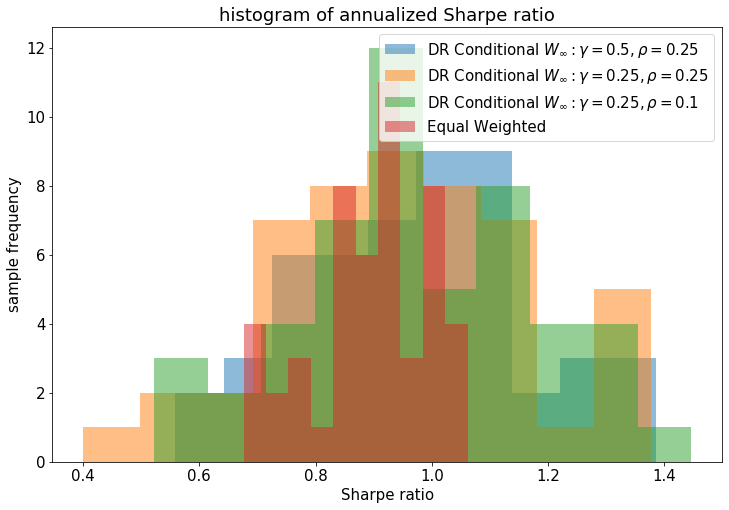

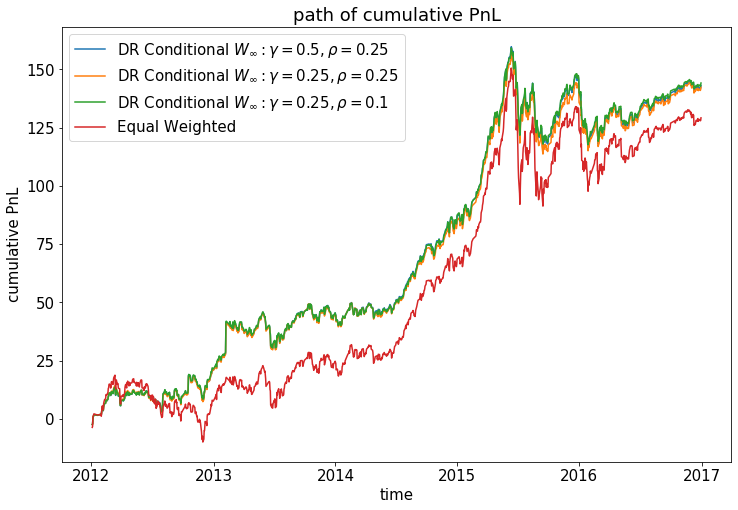

Sharpe Ratio:
DR Conditional $W_\infty:\gamma=0.5,\rho=0.25$    	mean:0.977	std:0.192
DR Conditional $W_\infty:\gamma=0.25,\rho=0.25$   	mean:0.940	std:0.215
DR Conditional $W_\infty:\gamma=0.25,\rho=0.1$    	mean:0.977	std:0.211
Equal Weighted                                    	mean:0.894	std:0.098
PnL stats:
DR Conditional $W_\infty:\gamma=0.5,\rho=0.25$    	mean:0.119	std:2.676
DR Conditional $W_\infty:\gamma=0.25,\rho=0.25$   	mean:0.118	std:2.709
DR Conditional $W_\infty:\gamma=0.25,\rho=0.1$    	mean:0.120	std:2.684
Equal Weighted                                    	mean:0.107	std:1.912


In [51]:
utils.backtest_result.plot_backtest_result(
    exp_num=50, seed=42, model_config_list=[model_config_1,model_config_2,model_config_3, equal_weight_model])